In [309]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import MinMaxScaler

In [310]:
def load_data(file_path):
    if file_path.endswith('.csv') or file_path.endswith('.txt'):
        data = pd.read_csv(file_path, header=None, sep='\s+')
        data.columns = [f"Column {i + 1}" for i in range(data.shape[1])]
    elif file_path.endswith('.xlsx'):
        data = pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file format. Use .csv, .txt, or .xlsx.")
    
    return data

In [311]:
file_path = 'D:/University/Data Analysis & Machine Learning 4 course/Lab 1/24th variant task.xlsx'
data = load_data(file_path)
data = data.dropna(axis=0, how='any')
print("Data Loaded:")
display(data)

Data Loaded:


,t36,t35,t34,t33,t32
0,300,312,245,234,223
1,320,302,300,256,201
2,270,221,221,212,199
3,320,243,220,220,198
4,300,223,200,195,200
5,330,202,234,234,212
6,245,200,223,223,188
7,250,234,222,222,211
8,250,234,198,211,189
9,245,220,221,189,201


In [312]:
def scale_data(data):
    data = ((data - data.min()) / (data.max() - data.min())) * 9 + 1
    return data

In [313]:
scaled_data = scale_data(data.copy())
scaled_data.describe()

,t36,t35,t34,t33,t32
count,29.000000,29.000000,29.000000,29.000000,29.000000
mean,6.285411,4.353238,3.881773,4.211119,3.121538
std,2.555335,2.633643,2.388978,2.054189,1.784015
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.115385,1.951220,2.371429,2.836735,2.475410
50%,6.330769,3.487805,3.314286,3.938776,2.622951
75%,7.923077,6.707317,4.342857,4.948980,3.508197
max,10.000000,10.000000,10.000000,10.000000,10.000000


In [314]:
scaled_data.head()

,t36,t35,t34,t33,t32
0,7.923077,10.000000,5.285714,5.959184,4.319672
1,9.307692,9.268293,10.000000,7.979592,2.696721
2,5.846154,3.341463,3.228571,3.938776,2.549180
3,9.307692,4.951220,3.142857,4.673469,2.475410
4,7.923077,3.487805,1.428571,2.377551,2.622951


In [315]:
def show_available_features(data):
    print("Available features (columns):")
    for i, column in enumerate(data.columns):
        print(f"{i + 1}: {column}")

In [316]:
show_available_features(data)

Available features (columns):
1: t36
2: t35
3: t34
4: t33
5: t32


In [317]:
feature_x = "t36"  # Replace with your desired feature
feature_y = "t33"  # Replace with your desired feature
print(f"Selected features: X-axis: {feature_x}, Y-axis: {feature_y}")

Selected features: X-axis: t36, Y-axis: t33


In [318]:
def build_scatter_plot(data, feature_x, feature_y):
    plt.scatter(data[feature_x], data[feature_y], s=50, alpha=0.6)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title("Scatter Plot of Selected Features")
    plt.show()

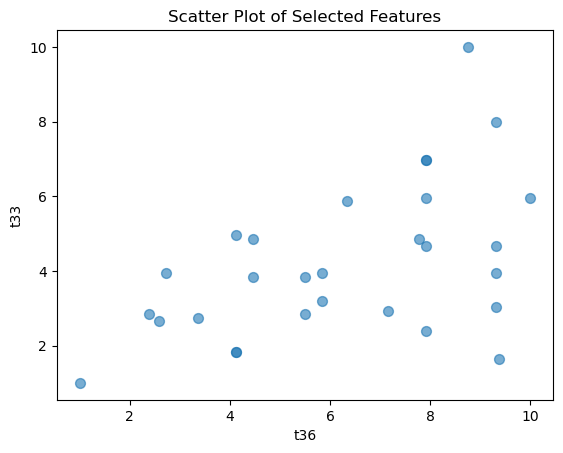

In [319]:
build_scatter_plot(scaled_data, feature_x, feature_y)

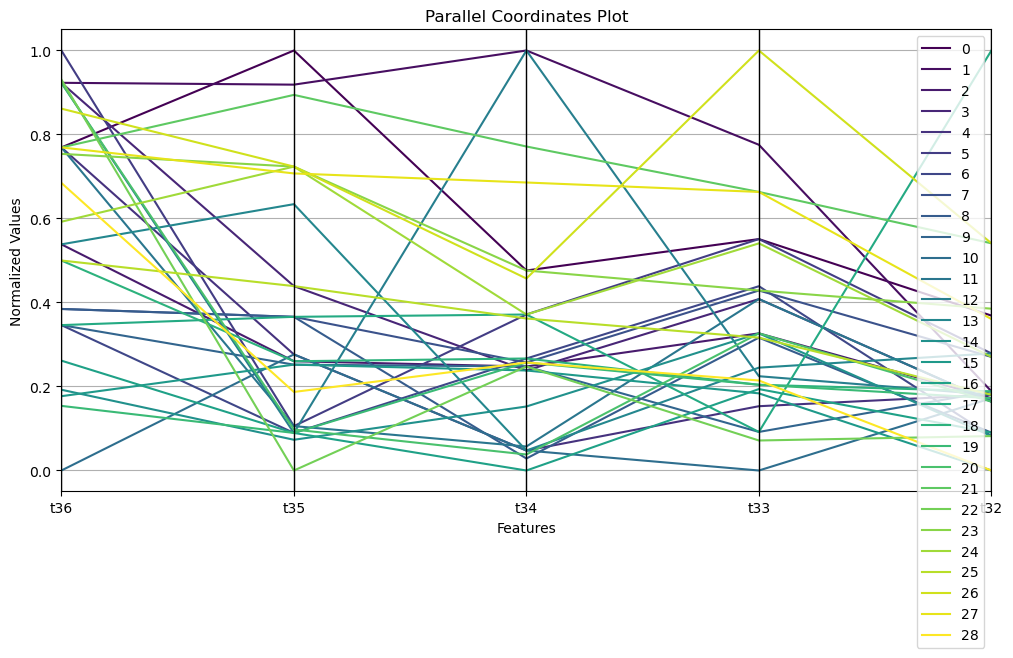

In [320]:
from pandas.plotting import parallel_coordinates

def parallel_coordinates_plot(data):
    normalized_data = MinMaxScaler().fit_transform(data)
    norm_df = pd.DataFrame(normalized_data, columns=data.columns)
    norm_df["Index"] = range(len(data))  # Add an index column for the plot
    
    plt.figure(figsize=(12, 6))
    parallel_coordinates(norm_df, "Index", colormap='viridis')
    plt.title("Parallel Coordinates Plot")
    plt.xlabel("Features")
    plt.ylabel("Normalized Values")
    plt.show()

parallel_coordinates_plot(scaled_data)

In [321]:
class KMeansClusteringML:
    def __init__(self, k=2):
        self.k = k
        self.centroids = None
        self.labels = None
    
    @staticmethod    
    def initialize_random_centroids(data, k):
        centroids = []
        for i in range(k):
            centroid = data.apply(lambda x: float(x.sample()))
            centroids.append(centroid)
        return pd.concat(centroids, axis=1)
    
    @staticmethod    
    def initialize_using_kmeans_plus_plus(data, k, random_state=42):
        np.random.seed(random_state)
    
        data_array = data.to_numpy()
    
        first_index = np.random.randint(0, data_array.shape[0])
        centroids = [data_array[first_index]]
    
        for _ in range(1, k):
            dist_sq = np.array([min(np.inner(c - x, c - x) for c in centroids) for x in data_array])
            probs = dist_sq / dist_sq.sum()
            cumulative_probs = probs.cumsum()
            r = np.random.rand()
            for j, p in enumerate(cumulative_probs):
                if r < p:
                    centroids.append(data_array[j])
                    break
    
        return pd.DataFrame(np.array(centroids).T, columns=range(k), index=data.columns)
    
    @staticmethod
    def get_labels(data, centroids):
        distances = centroids.apply(lambda x: np.sqrt(((data - x) ** 2).sum(axis = 1)))
        return distances.idxmin(axis=1)
    
    @staticmethod
    def new_centroids(data, labels, k):
        return data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T
    
    def fit(self, data, max_iterations=200):
        
        centroids = KMeansClusteringML.initialize_using_kmeans_plus_plus(data, self.k)
        old_centroids = pd.DataFrame()
        labels = None
        iteration = 1
        
        while iteration <= max_iterations and not centroids.equals(old_centroids):
            old_centroids = centroids
            labels = KMeansClusteringML.get_labels(data, centroids)
            centroids = KMeansClusteringML.new_centroids(data, labels, k = self.k)
            iteration += 1
        
        self.centroids = centroids
        self.labels = labels
        
        return labels

In [322]:
def kmeans_clustering(data, n_clusters):
    scaled_data = scale_data(data.copy())
    kmeans = KMeansClusteringML(n_clusters)
    kmeans.fit(scaled_data, 400)
    clustered_data = data.copy()
    clustered_data['Cluster'] = kmeans.labels
    return clustered_data, kmeans

In [323]:
n_clusters = 4
clustered_data, kmeans_model = kmeans_clustering(data, n_clusters)
display(clustered_data)

,t36,t35,t34,t33,t32,Cluster
0,300,312,245,234,223,1
1,320,302,300,256,201,1
2,270,221,221,212,199,2
3,320,243,220,220,198,3
4,300,223,200,195,200,3
5,330,202,234,234,212,3
6,245,200,223,223,188,0
7,250,234,222,222,211,2
8,250,234,198,211,189,2
9,245,220,221,189,201,2


In [324]:
def kmeans_clustering1(data, n_clusters):
    scaled_data = scale_data(data.copy())
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
    clusters = kmeans.fit_predict(scaled_data)
    clustered_data = data.copy()
    clustered_data['Cluster'] = clusters
    return clustered_data, kmeans

In [325]:
n_clusters = 4
clustered_data1, kmeans_model1 = kmeans_clustering1(data, n_clusters)
display(clustered_data1)

D:\Tools\AnacondaDistro\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,t36,t35,t34,t33,t32,Cluster
0,300,312,245,234,223,0
1,320,302,300,256,201,0
2,270,221,221,212,199,1
3,320,243,220,220,198,2
4,300,223,200,195,200,2
5,330,202,234,234,212,2
6,245,200,223,223,188,1
7,250,234,222,222,211,1
8,250,234,198,211,189,1
9,245,220,221,189,201,1


In [326]:
def calculate_cluster_means(data, cluster_col):
    cluster_means = data.groupby(cluster_col).mean()
    return cluster_means

In [327]:
cluster_means = calculate_cluster_means(clustered_data.copy(), 'Cluster')
print("Cluster Means:")
display(cluster_means)

Cluster Means:


,t36,t35,t34,t33,t32
Cluster,,,,,
0,224.5,206.833333,211.833333,202.000000,190.166667
1,301.0,289.000000,258.571429,244.714286,224.285714
2,257.5,234.250000,219.000000,204.750000,214.125000
3,312.5,209.000000,224.625000,208.875000,196.500000


In [328]:
def scatter_plot_clusters(data, feature_x, feature_y, cluster_col):
    plt.scatter(data[feature_x], data[feature_y], c=data[cluster_col], cmap='viridis', s=50, alpha=0.6)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title("Clustered Data (Scatter Plot)")
    plt.colorbar(label='Cluster')
    plt.show()

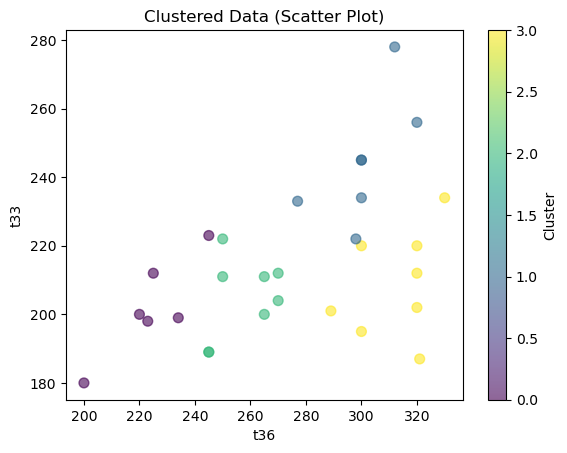

In [329]:
scatter_plot_clusters(clustered_data, feature_x, feature_y, 'Cluster')

In [330]:
def parallel_coordinates_clusters(data, cluster_col):
    plt.figure(figsize=(12, 6))
    parallel_coordinates(data, cluster_col, colormap='viridis')
    plt.title("Clustered Data (Parallel Coordinates Plot)")
    plt.show()

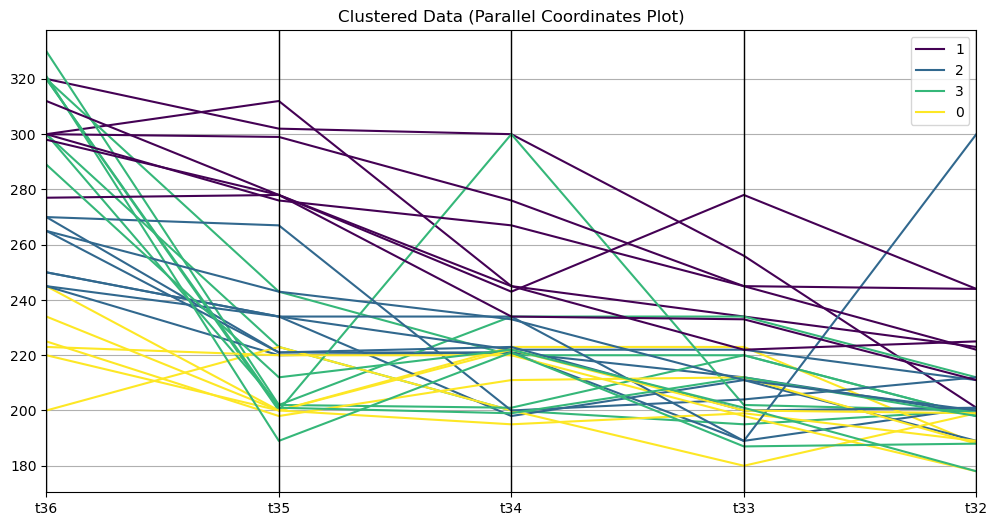

In [331]:
parallel_coordinates_clusters(clustered_data, 'Cluster')

In [332]:
def calculate_dunn_index(data, clusters):
    unique_clusters = np.unique(clusters)
    num_clusters = len(unique_clusters)
    
    if num_clusters < 2:
        raise ValueError("Dunn Index requires at least two clusters.")
    
    # Inter-cluster distances
    inter_distances = []
    for i in range(num_clusters):
        for j in range(i + 1, num_clusters):
            cluster_i = data[clusters == unique_clusters[i]]
            cluster_j = data[clusters == unique_clusters[j]]
            if cluster_i.size > 0 and cluster_j.size > 0:
                dist = np.min(pairwise_distances(cluster_i, cluster_j))
                inter_distances.append(dist)
    
    # Intra-cluster distances
    intra_distances = []
    for cluster in unique_clusters:
        cluster_points = data[clusters == cluster]
        if len(cluster_points) > 1:
            dist = np.max(pairwise_distances(cluster_points, cluster_points))
        else:
            dist = 0  # Single-point cluster
        intra_distances.append(dist)
    
    # Avoid division by zero
    if np.max(intra_distances) == 0:
        return np.inf  # Perfectly compact clusters
    
    # Calculate Dunn Index
    return np.min(inter_distances) / np.max(intra_distances)

In [333]:
dunn_for_current_clustering = calculate_dunn_index(scaled_data, kmeans_model.labels)
print(f"Dunn Index for {n_clusters} clusters: {dunn_for_current_clustering}")

Dunn Index for 4 clusters: 0.26310753049514796


In [282]:
results = []
for k in range(2, 10):
    _, kmeans_model = kmeans_clustering(data, k)
    dunn = calculate_dunn_index(scaled_data, kmeans_model.labels)
    results.append((k, dunn))

,Number of Clusters,Dunn Index
0,2,0.147062
1,3,0.178795
2,4,0.263108
3,5,0.196859
4,6,0.246409
5,7,0.301600
6,8,0.301600
7,9,0.317579


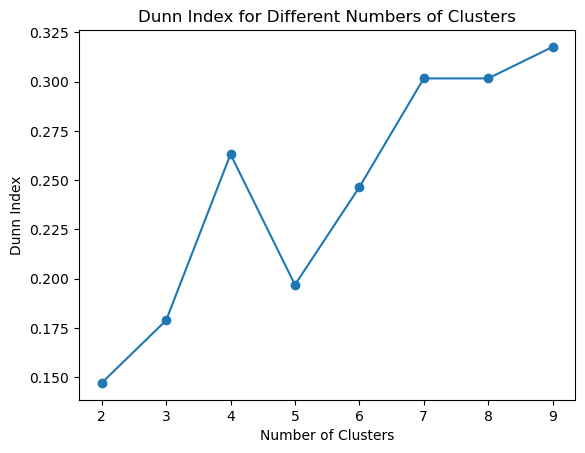

In [283]:
dunn_df = pd.DataFrame(results, columns=['Number of Clusters', 'Dunn Index'])
display(dunn_df)

# Plot results
plt.plot(dunn_df['Number of Clusters'], dunn_df['Dunn Index'], marker='o')
plt.title("Dunn Index for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Dunn Index")
plt.show()

In [102]:
def hierarchical_clustering(data):
    linkage_matrix = linkage(data, method='ward')
    return linkage_matrix

In [103]:
def display_linkage_matrix(linkage_matrix):
    linkage_df = pd.DataFrame(
        linkage_matrix,
        columns=["Cluster 1", "Cluster 2", "Distance", "Observations"]
    )
    display(linkage_df)

In [104]:
from scipy.spatial.distance import squareform

def display_linkage_as_matrix(linkage_matrix, labels=None):
    # Convert the condensed linkage matrix to a square distance matrix
    distance_matrix = squareform(linkage_matrix[:, 2])  # Extract distances
    
    # Create labels if none provided
    if labels is None:
        labels = [f"Cluster {i}" for i in range(len(distance_matrix))]
    
    # Create a DataFrame for better visualization
    distance_df = pd.DataFrame(distance_matrix, index=labels, columns=labels)
    
    return distance_df

In [105]:
linkage_matrix = hierarchical_clustering(data.copy())
display_linkage_matrix(linkage_matrix)

,Cluster 1,Cluster 2,Distance,Observations
0,2.0,18.0,1.177061,2.0
1,11.0,20.0,1.578505,2.0
2,14.0,19.0,1.703879,2.0
3,7.0,25.0,2.019915,2.0
4,23.0,24.0,2.256061,2.0
5,15.0,31.0,2.394307,3.0
6,21.0,27.0,2.461974,2.0
7,9.0,29.0,2.551332,3.0
8,16.0,34.0,2.667540,4.0
9,4.0,28.0,2.778719,2.0


In [106]:
distance_df = display_linkage_as_matrix(linkage_matrix)
display(distance_df)

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7
Cluster 0,0.000000,1.177061,1.578505,1.703879,2.019915,2.256061,2.394307,2.461974
Cluster 1,1.177061,0.000000,2.551332,2.667540,2.778719,3.194307,3.213127,3.224501
Cluster 2,1.578505,2.551332,0.000000,3.327031,3.554380,3.693102,3.913657,4.561226
Cluster 3,1.703879,2.667540,3.327031,0.000000,4.591684,4.852639,5.699603,5.733393
Cluster 4,2.019915,2.778719,3.554380,4.591684,0.000000,6.970255,8.420966,9.903466
Cluster 5,2.256061,3.194307,3.693102,4.852639,6.970255,0.000000,10.905230,15.947066
Cluster 6,2.394307,3.213127,3.913657,5.699603,8.420966,10.905230,0.000000,25.178310
Cluster 7,2.461974,3.224501,4.561226,5.733393,9.903466,15.947066,25.178310,0.000000


In [107]:
def plot_dendrogram(linkage_matrix):
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix, truncate_mode="lastp", p=30, leaf_rotation=90, leaf_font_size=10)
    plt.title("Dendrogram (Ward's Method)")
    plt.xlabel("Sample Index or Cluster Size")
    plt.ylabel("Distance")
    plt.show()

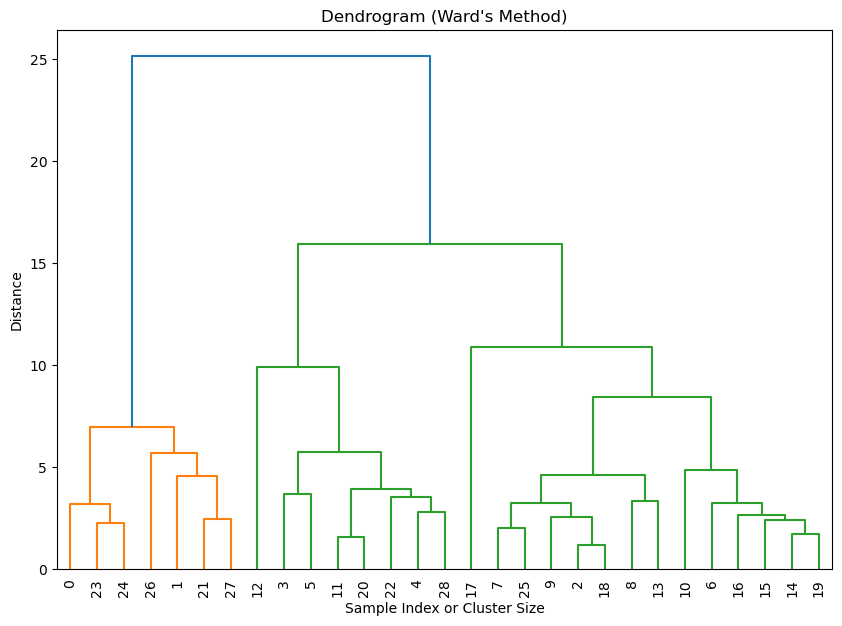

In [108]:
plot_dendrogram(linkage_matrix)